# ADCC experiment in python

## Prerequisite: download ADCC data

The following code fetches an experiment folder from Zenodo (https://zenodo.org/records/10650279), that is perfectly compatible with the software Celldetective, for demonstration purposes. Here we explore how to use some specific functions that are under the hood of the GUI. To optimize memory constraints, we developed a subprocess-based formulation for all the processing modules, that the software exploits. This approach locates a position in the experiment folder, reads the experiment metadata and writes directly on the disk the changes and output. In parallel, we propose a more direct and notebook-friendly functions that take input data and return the transformed or new data (*e.g.* image input, instance segmentation image output for the segmentation function).

* "position" mode: the subprocess approach
* "direct" mode: the i/o approach

In [1]:
from celldetective.utils import download_zenodo_file
import os
import numpy as np
import matplotlib.pyplot as plt

output_directory = '.'
# Download demo ADCC experiment locally
if not os.path.exists(os.sep.join([output_directory,'demo_adcc'])):
    download_zenodo_file('demo_adcc', output_directory)
exp = os.sep.join([output_directory, 'demo_adcc'])

api_mode = "direct" # "position" or "direct"
assert api_mode in ["position", "direct"],"Please select a valid api mode"

## Content of the experiment

The ***demo_adcc*** experiment contains a single well and a single position. All information about the experiment is contained in the configuration file of the experiment (channel order, biological conditions, spatio-temporal calibration...). Here we explore the contents of the wells and load the movie stack assoiated to the unique position. 

We imaged a co-culture of MCF-7 breast cancer cells (targets) and human primary NK cells (effectors), interacting in the presence of bispecific antibodies, to measure antibody dependent cellular cytotoxicity (ADCC). The nuclei of all cells are marked with the Hoechst nuclear stain, the dead nuclei with the propidium iodide nuclear stain, the cytoplasm of the NK cells with CFSE. The system in epifluorescence and brightfield 20X magnification. We are interested in detecting lysis events of the MCF-7 cells from the PI stain.

Experiment configuration file: ./demo_adcc/config.ini
Wells: ['./demo_adcc/W1/']
For well W1, found positions:  ['./demo_adcc/W1/100/']
Found 4 channels: ['brightfield_channel' 'dead_nuclei_channel' 'effector_fluo_channel'
 'live_nuclei_channel'], at indices [0 1 2 3]
Automatically detected stack length: 44...
Found stack of shape (44, 2048, 2048, 4)


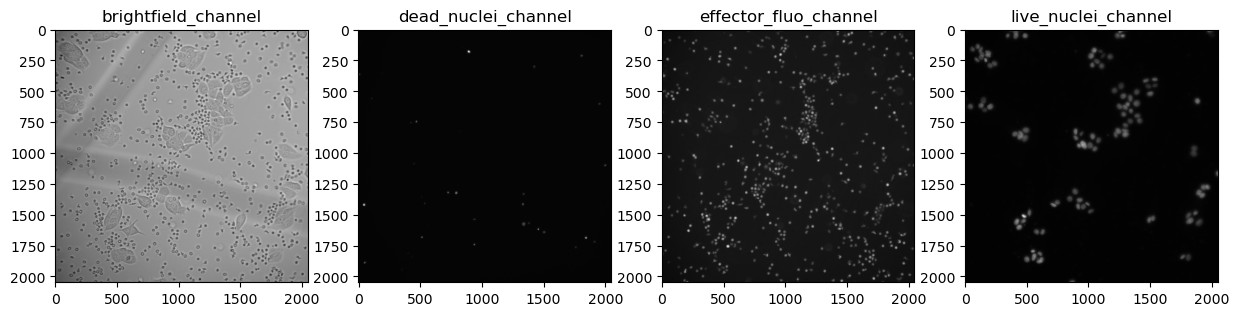

In [2]:
from celldetective.io import get_experiment_wells, get_positions_in_well, get_config, load_experiment_tables, extract_well_name_and_number, \
                             extract_experiment_channels, locate_stack, get_spatial_calibration, get_temporal_calibration

config = get_config(exp)
print(f'Experiment configuration file: {config}')
wells = get_experiment_wells(exp)
PxToUm = get_spatial_calibration(exp)
FrameToMin = get_temporal_calibration(exp)

print(f'Wells: {wells}')
pos = None
for well in wells:
    well_name, well_nbr = extract_well_name_and_number(well)
    positions = get_positions_in_well(well)
    print(f"For well {well_name}, found positions: ",positions)
    if len(positions)>0:
        pos = positions[0] # detect the only position in the demo

channel_names, channel_indices = extract_experiment_channels(config)
print(f"Found {len(channel_names)} channels: {channel_names}, at indices {channel_indices}")

# For the single position
stack = locate_stack(pos)
print(f"Found stack of shape {stack.shape}")

fig,ax = plt.subplots(1,4,figsize=(15,5))
for ch in range(stack.shape[-1]):
    ax[ch].imshow(stack[0,:,:,ch],cmap="gray")
    ax[ch].set_title(channel_names[channel_indices==ch][0])
plt.show()

## Processing

### Segmentation

In [3]:
from celldetective.io import get_segmentation_models_list

available_target_models = get_segmentation_models_list(mode='targets', return_path=False)
print(f"{available_target_models=}")

available_generalist_models = get_segmentation_models_list(mode='generic', return_path=False)
print(f"{available_generalist_models=}")

available_target_models=['mcf7_nuc_multimodal', 'mcf7_nuc_stardist_transfer']
available_generalist_models=['CP_cyto3', 'CP_livecell', 'CP_nuclei', 'CP_tissuenet', 'SD_versatile_fluo', 'SD_versatile_he']


Looking for mcf7_nuc_stardist_transfer in /home/torro/Documents/GitHub/celldetective/celldetective/models/segmentation*/
Loading input configuration from 'config_input.json'.
spatial_calibration=0.3112 required_spatial_calibration=0.3112 Scale = None...
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.489594, nms_thresh=0.3.
StarDist model mcf7_nuc_stardist_transfer successfully loaded.


frame: 100%|████████████████████████████████████| 44/44 [14:07<00:00, 19.27s/it]


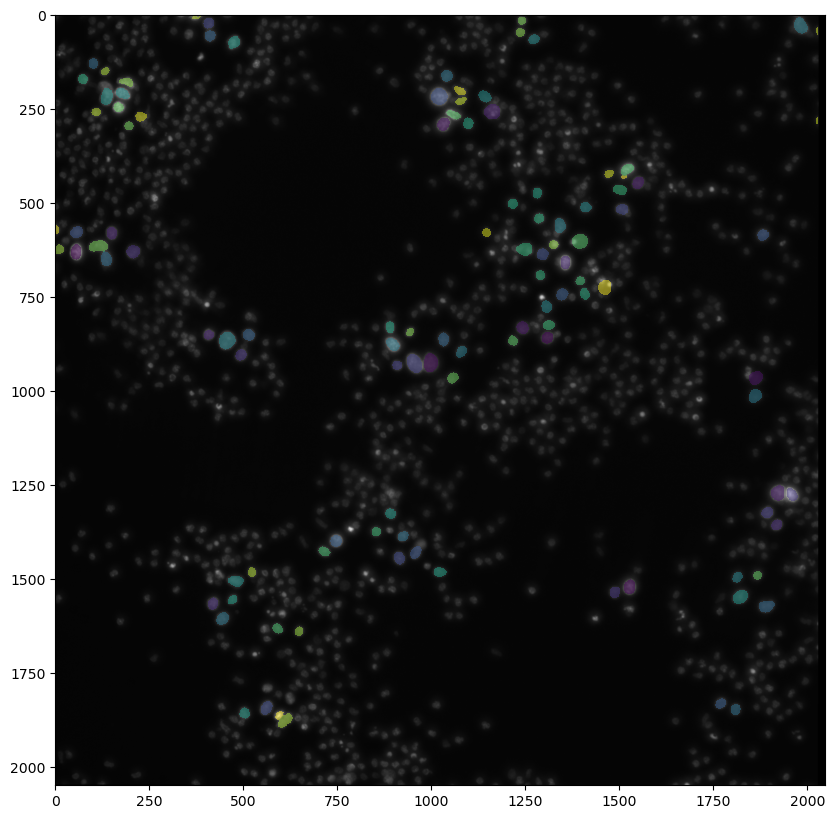

In [4]:
from celldetective.segmentation import segment_at_position, segment

model_name = "mcf7_nuc_stardist_transfer"
population = "targets"

if api_mode=="position":
    
    labels = segment_at_position(pos, population, model_name, use_gpu=True, return_labels=True, view_on_napari=False)
    
elif api_mode=="direct":
        
    labels = segment(stack, model_name, channels=list(channel_names), spatial_calibration=PxToUm, view_on_napari=False,
    			use_gpu=False) 
    
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(stack[-1,:,:,-1],cmap="gray")
ax.imshow(np.ma.masked_where(labels[-1]==0, labels[-1]),alpha=0.5)
plt.show()

### Tracking

frame: 100%|████████████████████████████████████| 44/44 [00:01<00:00, 28.23it/s]
[INFO][2024/12/16 01:55:11 PM] Objects are of type: <class 'pandas.core.frame.DataFrame'>
[INFO][2024/12/16 01:55:11 PM] Loaded btrack: /home/torro/mambaforge/lib/python3.10/site-packages/btrack/libs/libtracker.so
[INFO][2024/12/16 01:55:11 PM] Starting BayesianTracker session
[INFO][2024/12/16 01:55:11 PM] Loading configuration file: /home/torro/.cache/btrack-examples/examples/cell_config.json
[INFO][2024/12/16 01:55:11 PM] Objects are of type: <class 'list'>
[INFO][2024/12/16 01:55:11 PM] Starting tracking... 
[INFO][2024/12/16 01:55:11 PM] Update using: ['MOTION']
[INFO][2024/12/16 01:55:11 PM] Tracking objects in frames 0 to 44 (of 44)...


[INFO][2024/12/16 01:55:11 PM]  - Timing (Bayesian updates: 8.94ms, Linking: 0.67ms)
[INFO][2024/12/16 01:55:11 PM]  - Probabilities (Link: 0.77302, Lost: 1.00000)
[INFO][2024/12/16 01:55:11 PM] SUCCESS.
[INFO][2024/12/16 01:55:11 PM]  - Found 266 tracks in 44 frames (in 0.0s)
[INFO][2024/12/16 01:55:11 PM]  - Inserted 4 dummy objects to fill tracking gaps
[INFO][2024/12/16 01:55:11 PM] Loading hypothesis model: cell_hypothesis
[INFO][2024/12/16 01:55:11 PM] Calculating hypotheses (relax: True)...
[INFO][2024/12/16 01:55:11 PM] Setting up constraints matrix for global optimisation...
[INFO][2024/12/16 01:55:11 PM] Using GLPK options: {'tm_lim': 120000}...
[INFO][2024/12/16 01:55:11 PM] Optimizing...
[INFO][2024/12/16 01:55:11 PM] Optimization complete. (Solution: optimal)
[INFO][2024/12/16 01:55:11 PM]  - Fates.FALSE_POSITIVE: 112 (of 266)
[INFO][2024/12/16 01:55:11 PM]  - Fates.LINK: 25 (of 56)
[INFO][2024/12/16 01:55:11 PM]  - Fates.DIVIDE: 0 (of 11)
[INFO][2024/12/16 01:55:11 PM]  -

GLPK Integer Optimizer 5.0
1064 rows, 865 columns, 1209 non-zeros
865 integer variables, all of which are binary
Preprocessing...
532 rows, 865 columns, 1209 non-zeros
865 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 532
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
532 rows, 865 columns, 1209 non-zeros
*     0: obj =   1.739056001e+03 inf =   0.000e+00 (202)
*   209: obj =   5.187316467e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   209: mip =     not found yet >=              -inf        (1; 0)
+   211: >>>>>   5.192407887e+02 >=   5.192407887e+02   0.0% (3; 0)
+   211: mip =   5.192407887e+02 >=     tree is empty   0.0% (0; 5)
INTEGER OPTIMAL SOLUTION FOUND


,TRACK_ID,FRAME,POSITION_Y,POSITION_X,POSITION_X_um,POSITION_Y_um,t,state,generation,root,parent,dummy,class_id,velocity,class_firstdetection,t_firstdetection,ID
0,1.0,0.0,1553.357969,1819.524773,566.236109,483.405000,0.0,5.0,0.0,1.0,1.0,False,71.0,NaN,2.0,-1.0,0
1,1.0,1.0,1554.136383,1819.478170,566.221607,483.647242,1.0,5.0,0.0,1.0,1.0,False,70.0,0.475189,2.0,-1.0,1
2,1.0,2.0,1553.912882,1820.025186,566.391838,483.577689,2.0,5.0,0.0,1.0,1.0,False,61.0,0.817798,2.0,-1.0,2
3,1.0,3.0,1553.811938,1820.876124,566.656650,483.546275,3.0,5.0,0.0,1.0,1.0,False,65.0,0.710835,2.0,-1.0,3
4,1.0,4.0,1553.749599,1821.900883,566.975555,483.526875,4.0,5.0,0.0,1.0,1.0,False,64.0,0.720264,2.0,-1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4791,112.0,39.0,49.258790,1236.147679,384.689158,15.329336,39.0,5.0,0.0,112.0,112.0,False,88.0,0.656357,2.0,-1.0,4791
4792,112.0,40.0,48.382482,1235.321168,384.431947,15.056628,40.0,5.0,0.0,112.0,112.0,False,91.0,0.964722,2.0,-1.0,4792
4793,112.0,41.0,46.917986,1235.453237,384.473047,14.600877,41.0,5.0,0.0,112.0,112.0,False,91.0,1.033442,2.0,-1.0,4793
4794,112.0,42.0,46.367435,1236.020173,384.649478,14.429546,42.0,5.0,0.0,112.0,112.0,False,89.0,NaN,2.0,-1.0,4794


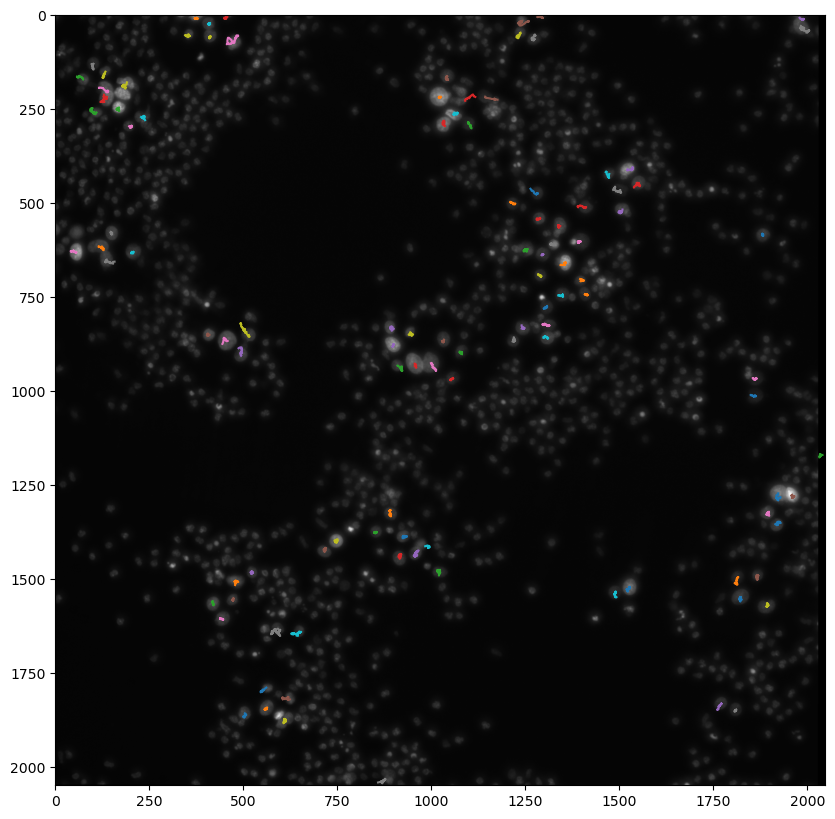

In [5]:
from celldetective.tracking import track_at_position, track

population = "targets"

if api_mode=="position":
    # not shown: reads the configs/tracking_instructions_targets.json in the experiment folder    
    tracks = track_at_position(pos, population, return_tracks=True)
    
elif api_mode=="direct":
        
    tracks = track(labels, configuration=None, stack=stack, spatial_calibration=PxToUm, features=None, channel_names=list(channel_names),
    		  view_on_napari=False, volume=(stack.shape[1],stack.shape[2]), optimizer_options = {'tm_lim': int(12e4)}, track_kwargs={'step_size': 100},
              clean_trajectories_kwargs={"minimum_tracklength": 10,"remove_not_in_first": True,"interpolate_position_gaps": True,"extrapolate_tracks_post": True})

display(tracks)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(stack[-1,:,:,-1],cmap="gray")
for tid,group in tracks.groupby("TRACK_ID"):
    ax.plot(group.POSITION_X, group.POSITION_Y)
plt.show()

### Measurements


In [6]:
from celldetective.measure import measure_at_position, measure

population = "targets"

if api_mode=="position":
    # not shown: reads the configs/measurement_instructions_targets.json in the experiment folder
    props =  measure_at_position(pos, population, return_measurements=True)

elif api_mode=="direct":
    # Perform custom measurements: features store regionprops measurements, define isotropic measurements, edge measurements...
    props = measure(stack=stack, labels=labels, trajectories=tracks, channel_names=list(channel_names),
    			features=["area", "intensity_mean"], intensity_measurement_radii=[10], isotropic_operations=['mean'], border_distances=[5],
    			haralick_options=None, clear_previous=True)

props['position'] = pos    
display(props.head(10))

frame: 100%|████████████████████████████████████| 44/44 [01:00<00:00,  1.38s/it]


,TRACK_ID,FRAME,POSITION_X,POSITION_Y,POSITION_X_um,POSITION_Y_um,class_id,t,state,generation,...,brightfield_channel_mean,dead_nuclei_channel_mean,effector_fluo_channel_mean,live_nuclei_channel_mean,brightfield_channel_mean_edge_5px,dead_nuclei_channel_mean_edge_5px,effector_fluo_channel_mean_edge_5px,live_nuclei_channel_mean_edge_5px,radial_distance,position
0,1.0,0.0,1819.524773,1553.357969,566.236109,483.405000,71.0,0.0,5.0,0.0,...,36250.644096,149.150289,271.876135,3777.627581,36263.094595,148.794840,273.793612,2900.337838,955.551947,./demo_adcc/W1/100/
1,1.0,1.0,1819.478170,1554.136383,566.221607,483.647242,70.0,1.0,5.0,0.0,...,36218.686071,150.558420,268.097297,3853.652391,36267.298765,150.767901,267.409877,2955.086420,955.944613,./demo_adcc/W1/100/
2,1.0,2.0,1820.025186,1553.912882,566.391838,483.577689,61.0,2.0,5.0,0.0,...,35867.683732,148.396780,275.955409,3654.977704,35880.503090,148.546354,276.134734,2820.746601,956.275985,./demo_adcc/W1/100/
3,1.0,3.0,1820.876124,1553.811938,566.656650,483.546275,65.0,3.0,5.0,0.0,...,35761.927637,150.910466,264.802944,3512.938267,35630.027094,150.701970,263.822660,2731.131773,956.928549,./demo_adcc/W1/100/
4,1.0,4.0,1821.900883,1553.749599,566.975555,483.526875,64.0,4.0,5.0,0.0,...,35613.905297,150.149679,255.667335,3387.822632,35354.958486,150.233211,255.203907,2638.284493,957.747595,./demo_adcc/W1/100/
5,1.0,5.0,1822.017473,1553.152377,567.011837,483.341020,67.0,5.0,5.0,0.0,...,35484.806583,149.913043,248.890289,3464.917513,35254.409594,149.490775,248.820418,2692.150062,957.514556,./demo_adcc/W1/100/
6,1.0,6.0,1822.855911,1552.946223,567.272760,483.276865,68.0,6.0,5.0,0.0,...,35183.309524,150.508210,260.112479,3399.357143,34898.905172,150.067734,260.742611,2686.777094,958.099616,./demo_adcc/W1/100/
7,1.0,7.0,1823.536595,1553.312911,567.484588,483.390978,64.0,7.0,5.0,0.0,...,34954.164062,159.636513,263.284951,3346.240132,34651.478475,162.686347,262.568266,2670.055351,958.869608,./demo_adcc/W1/100/
8,1.0,8.0,1825.563043,1553.200909,568.115219,483.356123,73.0,8.0,5.0,0.0,...,34779.571724,150.195122,253.253824,3238.018603,34493.264453,149.857319,252.397294,2624.771218,960.498263,./demo_adcc/W1/100/
9,1.0,9.0,1823.805801,1554.728878,567.568365,483.831627,61.0,9.0,5.0,0.0,...,35278.921396,151.522488,249.120639,3858.451030,35164.836431,151.679058,248.413879,2954.432466,959.876274,./demo_adcc/W1/100/


### Signal analysis


Looking for lysis_PI_area in /home/torro/Documents/GitHub/celldetective/celldetective/models/signal_detection//
Selecting the first time series among: ['dead_nuclei_channel_mean', 'dead_nuclei_channel_mean_edge_5px'] for input requirement dead_nuclei_channel_mean...
Selecting the first time series among: ['area'] for input requirement area...
The following channels will be passed to the model: ['dead_nuclei_channel_mean', 'area']


tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_object

tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
tracking.py (444): DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_object

Load pretrained models from /home/torro/Documents/GitHub/celldetective/celldetective/models/signal_detection/lysis_PI_area/...
Classifier successfully loaded...
Regressor successfully loaded...
Required channels read from pretrained model: ['dead_nuclei_channel_mean', 'area']
3/3 [==============================] - 1s 53ms/step
Done.


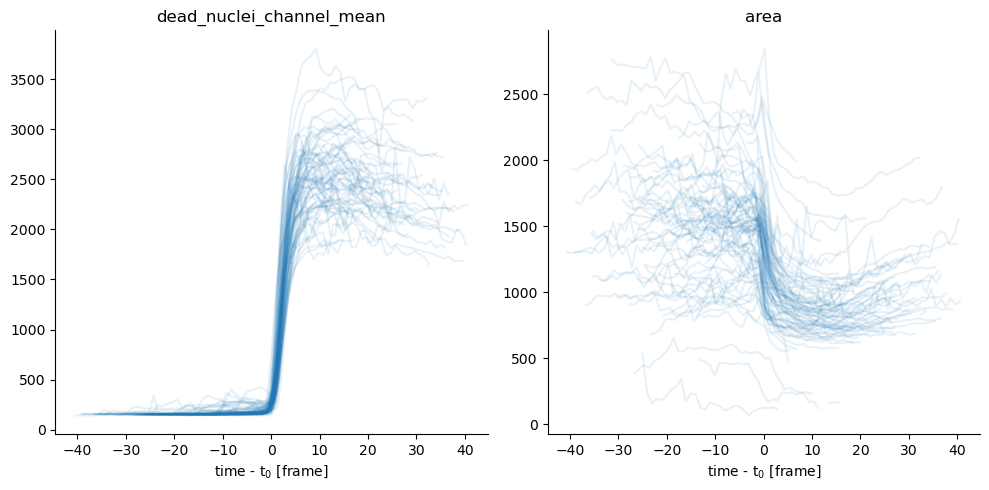

,TRACK_ID,FRAME,POSITION_X,POSITION_Y,POSITION_X_um,POSITION_Y_um,class_id,t,state,generation,...,dead_nuclei_channel_mean_edge_5px,effector_fluo_channel_mean_edge_5px,live_nuclei_channel_mean_edge_5px,radial_distance,position,class_death,t_death,status_death,status_color,class_color
0,1.0,0.0,1819.524773,1553.357969,566.236109,483.405000,71.0,0.0,5.0,0.0,...,148.794840,273.793612,2900.337838,955.551947,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
1,1.0,1.0,1819.478170,1554.136383,566.221607,483.647242,70.0,1.0,5.0,0.0,...,150.767901,267.409877,2955.086420,955.944613,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
2,1.0,2.0,1820.025186,1553.912882,566.391838,483.577689,61.0,2.0,5.0,0.0,...,148.546354,276.134734,2820.746601,956.275985,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
3,1.0,3.0,1820.876124,1553.811938,566.656650,483.546275,65.0,3.0,5.0,0.0,...,150.701970,263.822660,2731.131773,956.928549,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
4,1.0,4.0,1821.900883,1553.749599,566.975555,483.526875,64.0,4.0,5.0,0.0,...,150.233211,255.203907,2638.284493,957.747595,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
5,1.0,5.0,1822.017473,1553.152377,567.011837,483.341020,67.0,5.0,5.0,0.0,...,149.490775,248.820418,2692.150062,957.514556,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
6,1.0,6.0,1822.855911,1552.946223,567.272760,483.276865,68.0,6.0,5.0,0.0,...,150.067734,260.742611,2686.777094,958.099616,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
7,1.0,7.0,1823.536595,1553.312911,567.484588,483.390978,64.0,7.0,5.0,0.0,...,162.686347,262.568266,2670.055351,958.869608,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
8,1.0,8.0,1825.563043,1553.200909,568.115219,483.356123,73.0,8.0,5.0,0.0,...,149.857319,252.397294,2624.771218,960.498263,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red
9,1.0,9.0,1823.805801,1554.728878,567.568365,483.831627,61.0,9.0,5.0,0.0,...,151.679058,248.413879,2954.432466,959.876274,./demo_adcc/W1/100/,0.0,22.026339,0.0,tab:blue,tab:red


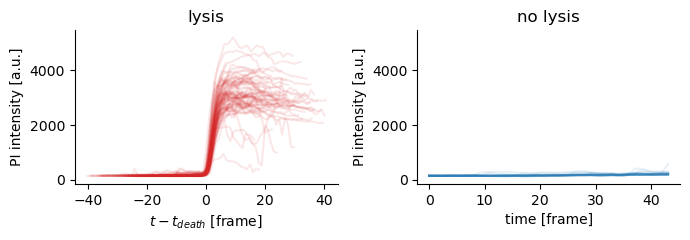

In [7]:
from celldetective.signals import analyze_signals_at_position, analyze_signals

model_name = "lysis_PI_area"
population = "targets"
feature_to_plot = 'dead_nuclei_channel_circle_10_mean'

if api_mode=="position":
    
    df_class = analyze_signals_at_position(pos, model_name, population, use_gpu=True, return_table=True)

elif api_mode=="direct":
        
    df_class = analyze_signals(props, model_name, interpolate_na=True, selected_signals=None, plot_outcome=True, output_dir=None)


df_class['position'] = pos
display(df_class.head(10))
# Plot results
fig,ax = plt.subplots(1,2,figsize=(7,2.5))
for tid, group in df_class.loc[df_class['class_death']==0].groupby('TRACK_ID'):
    timeline = group['FRAME'].values
    pi_signal = group[feature_to_plot].values
    t_lysis = group['t_death'].values[0]
    ax[0].plot(timeline - t_lysis, pi_signal,c='tab:red',alpha=0.1)
    ymin,ymax = ax[0].get_ylim()
    ax[0].set_title('lysis')
    ax[0].set_xlabel(r'$t - t_{death} $ [frame]')

for tid, group in df_class.loc[df_class['class_death']==1].groupby('TRACK_ID'):
    timeline = group['FRAME'].values
    pi_signal = group[feature_to_plot].values
    ax[1].plot(timeline, pi_signal,c='tab:blue',alpha=0.1)
    ax[1].set_ylim(ymin,ymax)
    ax[1].set_title('no lysis')
    ax[1].set_xlabel('time [frame]')
for a in ax:
    a.set_ylabel('PI intensity [a.u.]')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


## Analysis

### Mean response

A typical representation from single-cell signals is to collapse a signal with respect to an event time and show mean$\pm$std of the synchronized population response. 

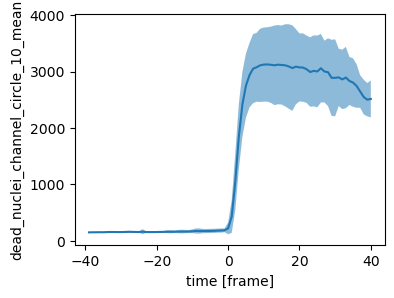

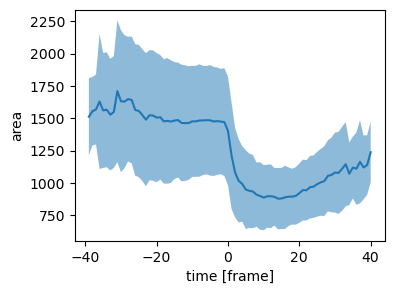

In [8]:
from celldetective.signals import mean_signal

feature = "dead_nuclei_channel_circle_10_mean"
cclass = 0
ms, std_signal, actual_timeline = mean_signal(df_class, feature, "class_death", time_col="t_death", class_value=[cclass], return_matrix=False, forced_max_duration=None, min_nbr_values=2)
fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.fill_between(actual_timeline, [a-b for a,b in zip(ms, std_signal)], [a+b for a,b in zip(ms, std_signal)], alpha=0.5)
ax.plot(actual_timeline, ms)
ax.set_xlabel("time [frame]")
ax.set_ylabel(feature)
plt.show()

feature = "area"
cclass = 0
ms, std_signal, actual_timeline = mean_signal(df_class, feature, "class_death", time_col="t_death", class_value=[cclass], return_matrix=False, forced_max_duration=None, min_nbr_values=2)
fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.fill_between(actual_timeline, [a-b for a,b in zip(ms, std_signal)], [a+b for a,b in zip(ms, std_signal)], alpha=0.5)
ax.plot(actual_timeline, ms)
ax.set_xlabel("time [frame]")
ax.set_ylabel(feature)
plt.show()

### Survival

Alternatively, we can exploit the $\Delta t$ between two events (here between the beginning of the movie at $T = 0$ and $t_\textrm{lysis}$) to define a survival function, showing the event rate and fraction of cells that exhibit the event.

<Axes: xlabel='timeline'>

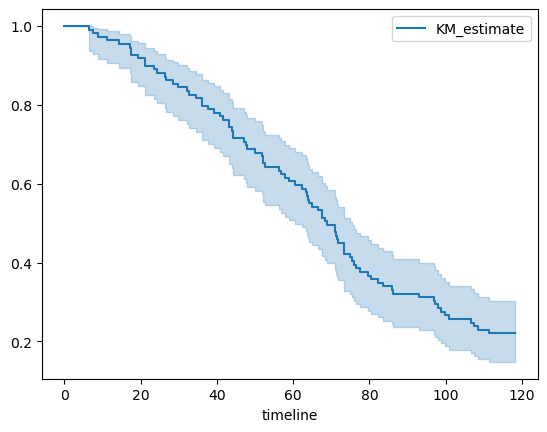

In [9]:
from celldetective.events import compute_survival


ks = compute_survival(df_class, "class_death", "t_death", t_reference="0", FrameToMin=FrameToMin)
ks.plot_survival_function()